# **Text classification with an RNN**

In [ ]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']
train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
for example, label in train_dataset.take(5):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0
text:  b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. 

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'Julian Noble (Pierce Brosnan) is a hit-man. Or a "facilitator of fatalities", as he prefers to be called. He is also a drunk, a womaniser, and in the middle of a mid-life crisis. On a job in Mexico City, he bumps into Danny White (Greg Kinnear), an unconfident businessman who thinks he\'s just nailed a recent pitch, but is unsure. They meet in the hotel bar late one night, after they\'ve both had a few too many margaritas.<br /><br />Sounds like the set-up for a by-the-numbers comedy thriller, doesn\'t it? But it isn\'t. Instead, The Matador is a funny and sometimes touching character study. It avoids every twist that the above summary would suggest, sometimes even setting them up just to gleefully tear them down. It is a film that respects it characters enough to just let them get on with it, without feeling the need to shove them into needless plot contrivances.<br /><br />Brosnan\'s hit-man will inevitably be compared to his Bond, but this is unfair to both performances. 

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  1,   1,   1, ...,   0,   0,   0],
       [ 51,   9, 366, ...,   0,   0,   0],
       [ 48,  24,  38, ...,   0,   0,   0]])

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'Julian Noble (Pierce Brosnan) is a hit-man. Or a "facilitator of fatalities", as he prefers to be called. He is also a drunk, a womaniser, and in the middle of a mid-life crisis. On a job in Mexico City, he bumps into Danny White (Greg Kinnear), an unconfident businessman who thinks he\'s just nailed a recent pitch, but is unsure. They meet in the hotel bar late one night, after they\'ve both had a few too many margaritas.<br /><br />Sounds like the set-up for a by-the-numbers comedy thriller, doesn\'t it? But it isn\'t. Instead, The Matador is a funny and sometimes touching character study. It avoids every twist that the above summary would suggest, sometimes even setting them up just to gleefully tear them down. It is a film that respects it characters enough to just let them get on with it, without feeling the need to shove them into needless plot contrivances.<br /><br />Brosnan\'s hit-man will inevitably be compared to his Bond, but this is unfair to both performances

# **create the model**

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 7s 7s/step
[0.01760729]


In [ ]:
padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 69ms/step
[0.01760729]


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

# **Train the model**

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 50s 102ms/step - loss: 0.6380 - accuracy: 0.5784 - val_loss: 0.4625 - val_accuracy: 0.7932
Epoch 2/10
391/391 [==============================] - 26s 65ms/step - loss: 0.3921 - accuracy: 0.8252 - val_loss: 0.3718 - val_accuracy: 0.8458
Epoch 3/10
391/391 [==============================] - 24s 61ms/step - loss: 0.3375 - accuracy: 0.8519 - val_loss: 0.3378 - val_accuracy: 0.8562
Epoch 4/10
391/391 [==============================] - 23s 59ms/step - loss: 0.3214 - accuracy: 0.8593 - val_loss: 0.3298 - val_accuracy: 0.8557
Epoch 5/10
391/391 [==============================] - 24s 61ms/step - loss: 0.3139 - accuracy: 0.8643 - val_loss: 0.3301 - val_accuracy: 0.8578
Epoch 6/10
391/391 [==============================] - 22s 56ms/step - loss: 0.3120 - accuracy: 0.8654 - val_loss: 0.3479 - val_accuracy: 0.8339
Epoch 7/10
391/391 [==============================] - 23s 58ms/step - loss: 0.3099 - accuracy: 0.8664 - val_loss: 0.3403 - val_accuracy

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 11s 28ms/step - loss: 0.3190 - accuracy: 0.8582
Test Loss: 0.31899458169937134
Test Accuracy: 0.8581600189208984


(0.0, 0.6548959612846375)

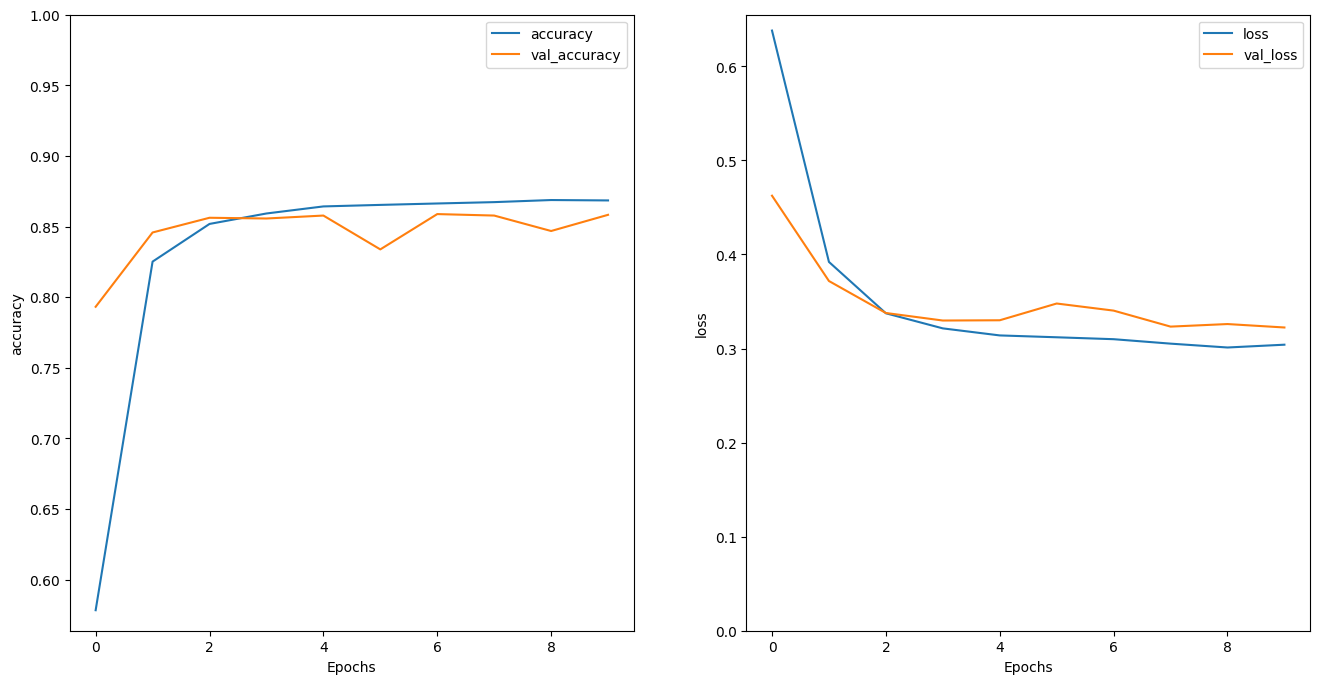

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)


In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 2s 2s/step


In [ ]:
predictions

array([[0.52940834]], dtype=float32)

# **Stack two or more LSTM layers**

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:

history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 75s 149ms/step - loss: 0.6290 - accuracy: 0.5917 - val_loss: 0.4439 - val_accuracy: 0.7974
Epoch 2/10
391/391 [==============================] - 43s 110ms/step - loss: 0.3913 - accuracy: 0.8330 - val_loss: 0.3592 - val_accuracy: 0.8557
Epoch 3/10
391/391 [==============================] - 43s 108ms/step - loss: 0.3374 - accuracy: 0.8553 - val_loss: 0.3515 - val_accuracy: 0.8578
Epoch 4/10
391/391 [==============================] - 42s 106ms/step - loss: 0.3192 - accuracy: 0.8632 - val_loss: 0.3317 - val_accuracy: 0.8531
Epoch 5/10
391/391 [==============================] - 42s 107ms/step - loss: 0.3111 - accuracy: 0.8660 - val_loss: 0.3187 - val_accuracy: 0.8505
Epoch 6/10
391/391 [==============================] - 42s 106ms/step - loss: 0.3049 - accuracy: 0.8688 - val_loss: 0.3355 - val_accuracy: 0.8667
Epoch 7/10
391/391 [==============================] - 42s 107ms/step - loss: 0.3024 - accuracy: 0.8714 - val_loss: 0.3201 - val_ac

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 17s 44ms/step - loss: 0.3228 - accuracy: 0.8566
Test Loss: 0.32278767228126526
Test Accuracy: 0.8565999865531921


In [ ]:
sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 4s 4s/step
[[-1.9389673]]


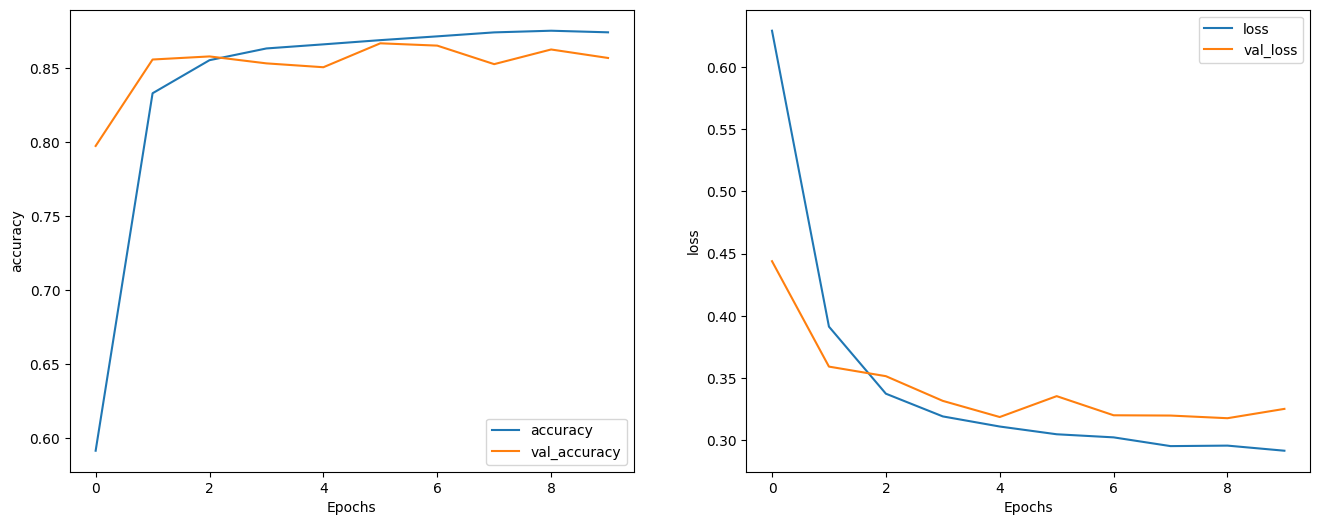

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')